# ProShares Replication

## HBS Case

### *ProShares Hedge Replication ETF*

***

# 1. READING - The ProShares ETF Product

### 1. Alternative ETFs

Describe the two types of investments referenced by this term.

Alternative Asset classes
* Give exposure to nonmanstream assets

Alternative Strategies
* Pursuing investment processes that were not constrained and could use leverage, shorting and derivatives

![ETF Investments](cases/ETF%20investments.png)

### 2. Hedge Funds.

* a. Using just the information in the case, what are two measures by which hedge funds are an attractive investment?

* b. What are the main benefits of investing in hedge funds via an ETF instead of directly?

* a. Their Ability to deliver absolute returns in varied market conditions, and to be able to access liquid alternatives. 
    Oh this is wrong it is their performance, having 10% higher returns than stocks, and double performance of bonds. The other is an impressive Sharpe Ratio, with less than half the volatility of the S & P 500. Both of these are referencing returns of HFRI
* b. It is cheaper - to invest in an hedge fund you need to have millions, I guess also here your investment is more diversified, with similar returns but reduced risk. There are restrctive terms on when you can withdraw money. Little Transparency, high fees. Less regulated. Then made taxes morecomplicated/could delay

### 3. The Benchmarks

* a. Explain as simply as possible how HFRI, MLFM, MLFM-ES, and HDG differ in their construction and purpose.

* b. How well does the Merrill Lynch Factor Model (MLFM) track the HFRI?

* c. In which factor does the MLFM have the largest loading? (See a slide in Exhibit 1.)

* d. What are the main concerns you have for how the MLFM attempts to replicate the HFRI?

- a. 
    - HFRI: equal weighting of >2,000 hedge funds, tracks the actual reported returns of hedge funds across styles
        - Purpose: Measures aggregate hedge-fund performance (hedge-fund “beta”). Not investable; serves as the reference target that replication models aim to mimic.
    - MLFM: Statistical returns-based regression on six liquid market factors: S&P 500, Russell 2000, MSCI EAFE, MSCI Emerging Markets, Eurodollar/USD exchange rate, and 3-month Eurodollar deposit yields . Rolling 24-month regression updated monthly.
        - Purpose: A quantitative model designed to replicate the risk/return behavior of HFRI without investing in hedge funds-thus providing a synthetic hedge-fund “beta.”
    - MLFM-ES: 2011 tradable version of MLFM. Replaces non-tradable factors: swaps Eurodollar yield → U.S. T-Bills and Euro FX → ProShares UltraShort Euro (EUO). Correlation ≈ 0.997 with MLFM .
        - Purpose: Serves as an ETF-eligible benchmark index-transparent, rule-based, and replicable using exchange-traded instruments.
    - HDG: ETF that tracks MLFM-ES using a mix of long/short physical (stocks/bonds) and synthetic (swaps/futures) positions.   
        - Purpose: Provides retail investors with liquid, low-fee access to hedge-fund-like returns (“hedge-fund beta”) with daily transparency and 1099 tax reporting.
- b. It tracked well with a correlation coef of 90%, but in 2008 there was a positive tracking error and then from 2012 - 2013 it trailed
* c. S&P 500
* d. 
    - Backward-looking regression: Weights are estimated from past 24 months, so the model lags changes in hedge-fund styles.
    - Only six traditional betas (equity and rates) are included-omitting alternative betas like credit spreads, carry, volatility, or illiquidity.
    - Liquidity vs. alpha trade-off: Replication captures only systematic beta, not the manager skill (alpha) from illiquid or niche strategies.
    - Model instability and over-simplification: The rolling-window regression may overfit past data and fail to generalize in stress periods (e.g., 2008).

### 4. The HDG Product

* a. What does ProShares ETF, HDG, attempt to track? Is the tracking error small?

* b. HDG is, by construction, delivering beta for investors. Isn't the point of hedge funds to generate alpha? Then why would HDG be valuable?

* c. The fees of a typical hedge-fund are 2% on total assets plus 20% of excess returns if positive. HDG's expense ratio is roughly 1% on total assets. What would their respective net Sharpe Ratios be, assuming both have a gross excess returns of 10% and volatility of 20%?

- a. HDG closely tracks the MLFM-ES, which in turn tracks the HFRI with high correlation (≈ 0.9). Thus, the tracking error is small but non-zero, reflecting model lag and structural simplifications.
- b. Although HDG cannot deliver hedge-fund alpha, it provides cheap, liquid, transparent access to the systematic component (beta) of hedge-fund returns-an attractive proposition for many investors.
- c. $S_{HDG} = 0.45 S_{HF} = 0.3 \implies$ HDG would offer a higher risk-adjusted return(Sharpe ratio) taking into account fees 

***

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm

In [175]:
file = "data/proshares_analysis_data.xlsx"

df = pd.read_excel(file, sheet_name="hedge_fund_series")
df.columns.values[0] = "Date"
df = df.set_index("Date")
df.head()

merrill_factors = pd.read_excel(file, sheet_name="merrill_factors")
merrill_factors.columns.values[0] = "Date"
merrill_factors = merrill_factors.set_index("Date")

spy = merrill_factors["SPY US Equity"]

# 2.  Analyzing the Data

Use the data found on Canvas, in <b>'proshares analysis data.xlsx'</b>. 

It has monthly data on financial indexes and ETFs from `Aug 2011` through `May 2025`.

## 1. 

For the series in the "hedge fund series" tab, report the following summary statistics:
* mean
* volatility
* Sharpe ratio

Annualize these statistics.

In [162]:
cols = df.select_dtypes(include="number")

mean = cols.mean()
vol = cols.std(ddof=1)

#annualize
mean *= 12
vol *= np.sqrt(12)

stats = pd.DataFrame({"mean": mean, "vol": vol})
stats["sharpe"] = stats["mean"] / stats["vol"]

display(stats)

,mean,vol,sharpe
HFRIFWI Index,0.051279,0.058796,0.872151
MLEIFCTR Index,0.038535,0.055240,0.697589
MLEIFCTX Index,0.036526,0.055102,0.662880
HDG US Equity,0.026880,0.057388,0.468396
QAI US Equity,0.028811,0.049823,0.578275


## 2.

For the series in the "hedge fund series" tab, calculate the following statistics related to tail-risk.
* Skewness
* Excess Kurtosis (in excess of 3)
* VaR (.05) - the fifth quantile of historic returns
* CVaR (.05) - the mean of the returns at or below the fifth quantile
* Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.

There is no need to annualize any of these statistics.

In [163]:
def max_drawdown_info(returns: pd.Series) -> pd.Series:
    r = pd.to_numeric(returns, errors="coerce").dropna()
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = 1 - cum / peak

    trough_date = dd.idxmax()
    max_dd = dd.loc[trough_date]
    peak_date = cum.loc[:trough_date].idxmax()

    recovery = cum.loc[trough_date:]
    recovery_date = recovery[recovery >= cum.loc[peak_date]].first_valid_index()

    return pd.Series({
        "max_drawdown": float(max_dd),
        "peak_date": peak_date,
        "trough_date": trough_date,
        "recovery_date": recovery_date
    })

def plot_max_drawdown(returns, title: str | None = None):
    if isinstance(returns, pd.DataFrame):
        for name, s in returns.items():
            plot_max_drawdown(s, title=name if title is None else f"{title} - {name}")
        return

    r = pd.to_numeric(returns, errors="coerce").dropna()
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = 1 - cum / peak

    # dates are the index now (DatetimeIndex)
    info = max_drawdown_info(r)
    peak_date, trough_date, recovery_date = info["peak_date"], info["trough_date"], info["recovery_date"]
    mdd = info["max_drawdown"]

    end_for_shade = recovery_date if pd.notna(recovery_date) else cum.index[-1]
    mask = (cum.index >= peak_date) & (cum.index <= end_for_shade)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(cum.index, cum.values, label="Cumulative Return")
    ax.plot(peak.index, peak.values, linestyle="--", label="Running Peak")
    ax.fill_between(cum.index[mask], cum.values[mask], peak.values[mask], alpha=0.3, label="Drawdown")

    ax.axvline(peak_date, linestyle=":", label="Peak")
    ax.axvline(trough_date, linestyle=":", label="Trough")
    if pd.notna(recovery_date):
        ax.axvline(recovery_date, linestyle=":", label="Recovery")

    ttl = title if title is not None else "Maximum Drawdown"
    ax.set_title(f"{ttl} - MDD: {mdd:.2%}")
    ax.set_ylabel("Cumulative Growth of $1")
    ax.legend()
    fig.autofmt_xdate()
    plt.show()

    # Drawdown curve
    fig2, ax2 = plt.subplots(figsize=(10, 3))
    ax2.plot(dd.index, dd.values, label="Drawdown")
    ax2.axhline(0.0, linestyle="--")
    ax2.axvline(trough_date, linestyle=":", label="Max DD Trough")
    ax2.set_title("Drawdown")
    ax2.set_ylabel("Fraction below peak")
    ax2.legend()
    fig2.autofmt_xdate()
    plt.show()


,mean,vol,sharpe,skew,kurtosis,VaR,CVaR
HFRIFWI Index,0.051279,0.058796,0.872151,-0.948272,5.657351,-0.024008,-0.035992
MLEIFCTR Index,0.038535,0.055240,0.697589,-0.289982,1.630917,-0.027002,-0.034993
MLEIFCTX Index,0.036526,0.055102,0.662880,-0.273477,1.589790,-0.026970,-0.034937
HDG US Equity,0.026880,0.057388,0.468396,-0.274904,1.776481,-0.029919,-0.036831
QAI US Equity,0.028811,0.049823,0.578275,-0.433508,1.449184,-0.017171,-0.030995


,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
max_drawdown,0.115473,0.124302,0.124388,0.14072,0.137716
peak_date,2019-12-31 00:00:00,2021-06-30 00:00:00,2021-06-30 00:00:00,2021-06-30 00:00:00,2021-06-30 00:00:00
trough_date,2020-03-31 00:00:00,2022-09-30 00:00:00,2022-09-30 00:00:00,2022-09-30 00:00:00,2022-09-30 00:00:00
recovery_date,2020-08-31 00:00:00,2024-02-29 00:00:00,2024-02-29 00:00:00,2024-07-31 00:00:00,2024-02-29 00:00:00


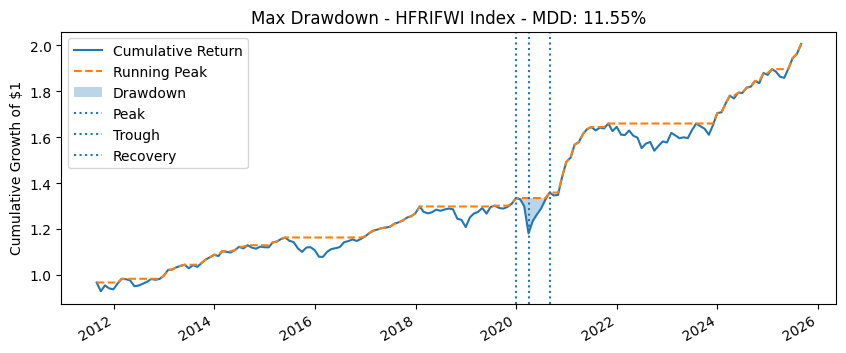

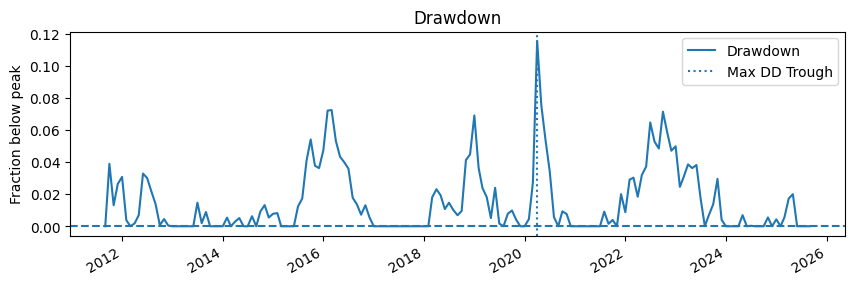

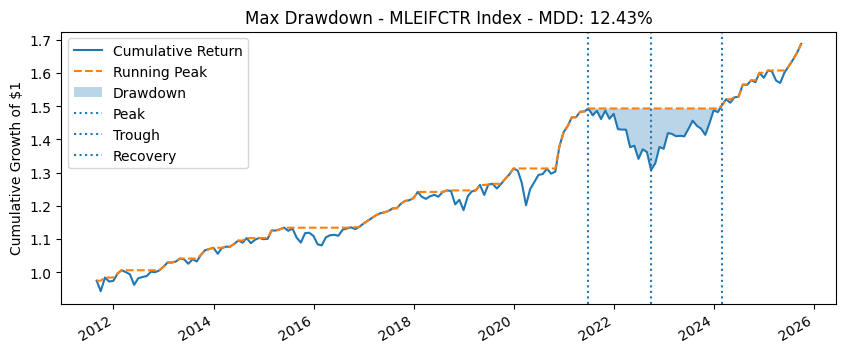

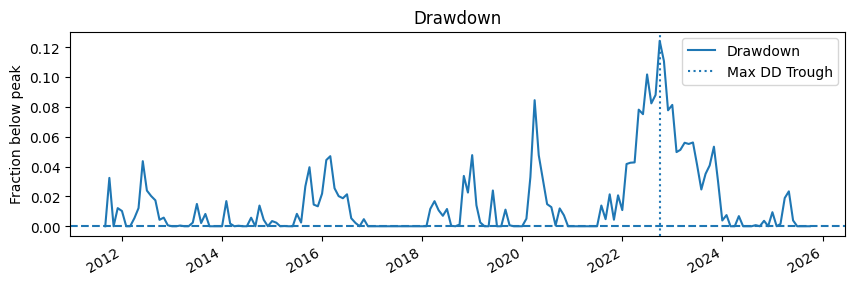

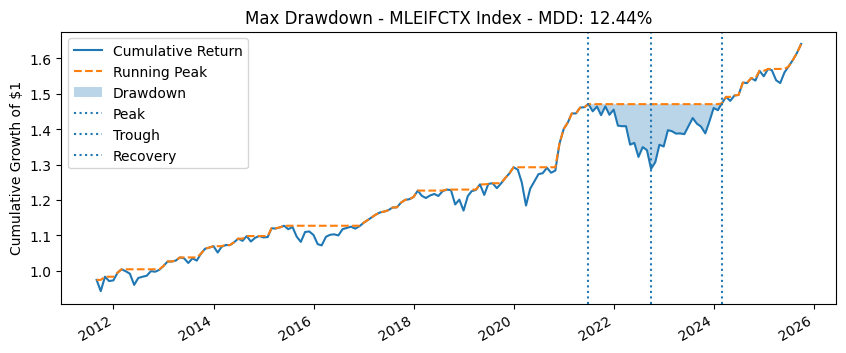

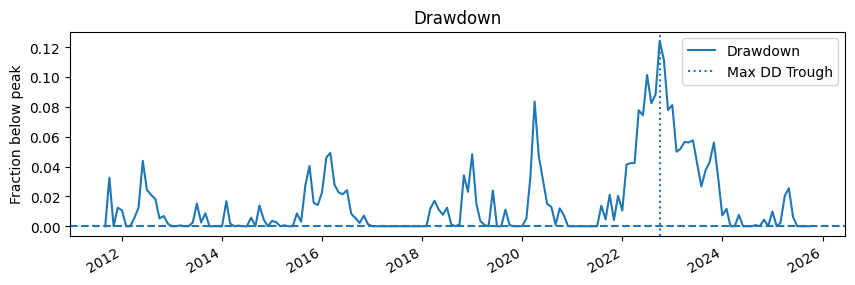

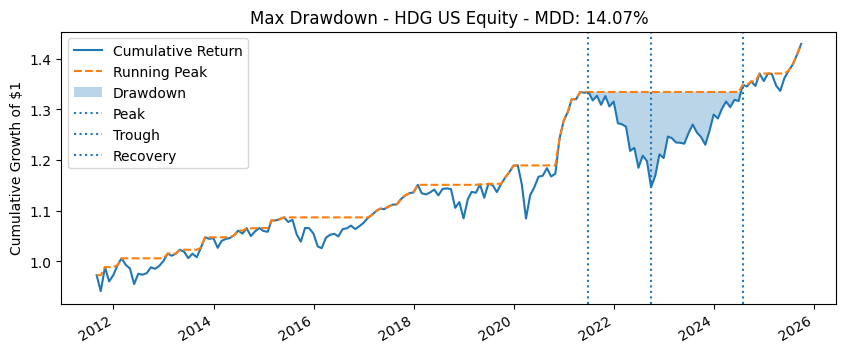

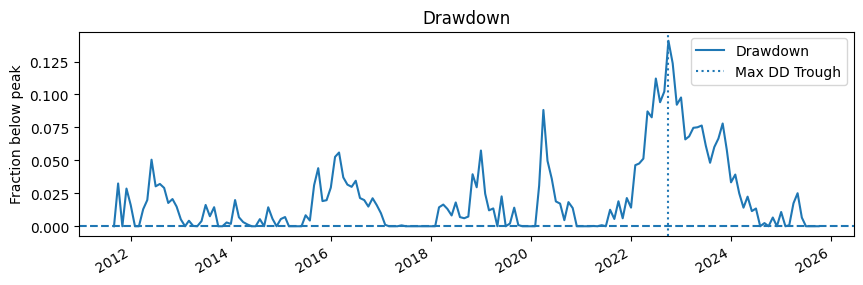

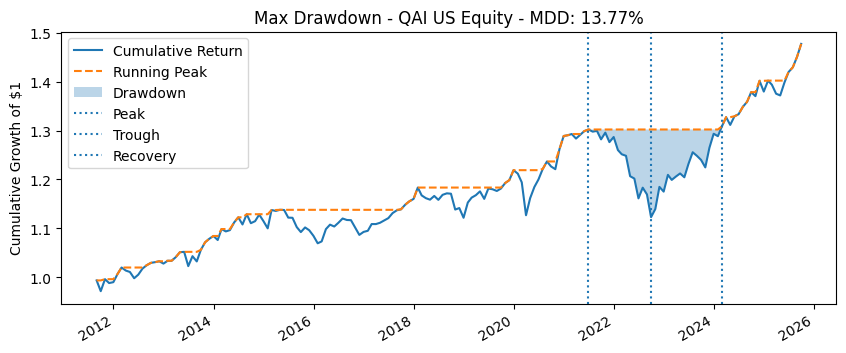

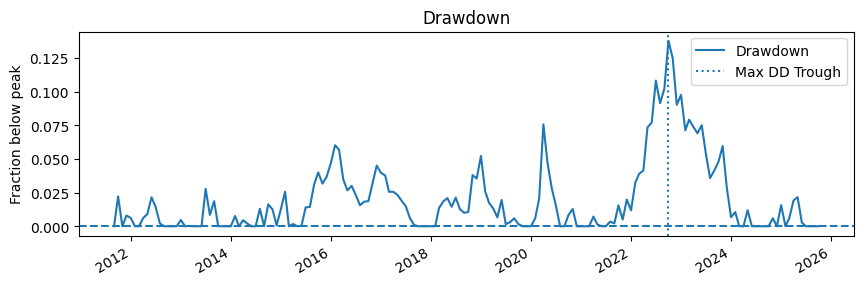

In [164]:
stats["skew"] = cols.skew() # Third degree of mean - std
stats["kurtosis"] = cols.kurt() # Fourth Degree
stats["VaR"]= cols.quantile(0.05) # Value at risk 
stats["CVaR"] = cols[cols <= stats["VaR"]].mean() # average of vals below Var

display(stats)
mdd_stats = df.apply(lambda s: max_drawdown_info(s))
display(mdd_stats)

plot_max_drawdown(df, title="Max Drawdown")


## 3. 

For the series in the "hedge fund series" tab, run a regression of each against SPY (found in the "merrill factors" tab.) Include an intercept. Report the following regression-based statistics:
* Market Beta
* Treynor Ratio
* Information ratio

Annualize these three statistics as appropriate.

In [165]:
aligned = cols.join(spy.rename("SPY"), how="inner")
R = aligned[cols.columns]
M = aligned["SPY"]

# Add constant for intercept
X = sm.add_constant(M)

# Create empty DataFrame with funds as rows and metrics as columns
regression_stats = pd.DataFrame(columns=["Market Beta", "Treynor Ratio", "Information Ratio"], index=R.columns)

# Loop over each hedge fund series
for hf in R.columns:
    y = R[hf]
    model = sm.OLS(y, X, missing="drop").fit()

    alpha = model.params["const"]
    beta = model.params["SPY"]
    resid_std = model.resid.std(ddof=1)

    # Annualized Treynor and Appraisal (CAPM) IR
    treynor = 12 * y.mean() / beta
    ir = np.sqrt(12) * alpha / resid_std

    regression_stats.loc[hf] = [beta, treynor, ir]

# Round and display
regression_stats = regression_stats.astype(float).round(3)
display(regression_stats)

,Market Beta,Treynor Ratio,Information Ratio
HFRIFWI Index,0.346,0.148,0.055
MLEIFCTR Index,0.342,0.113,-0.436
MLEIFCTX Index,0.341,0.107,-0.511
HDG US Equity,0.351,0.077,-0.862
QAI US Equity,0.301,0.096,-0.598


## 4. 

Discuss the previous statistics, and what they tell us about...

* the differences between SPY and the hedge-fund series?
* which performs better between HDG and QAI.
* whether HDG and the ML series capture the most notable properties of HFRI.

The differences between SPY and the hedge-fund series?
* All of the hedge funs have a Market beta of ~0.34 meaning that for every 1% change in SPY, the hedge funds move 0.34% so a low exposure to the markets
* Similarly, there Treynor Ratio's are between 0.075 and 0.15, meaning that they have miodest risk-adjusted efficiency relative to systematic exposure
* The information ratio's range from 0.055 to -0.85, with most being negative meaning that they are underperforming the benchmark(SPY)

Which performs better between HDG and QAI?
* HDG has a larger market beta (0.35 vs 0.3) meaning that it takes more risk, but a lower treynor ratio (0.076 v 0.095), so QAI is more efficent in converting systemic risk into return and a worse information ratio(-0.862 v -0.598) so it underperforms SPY more than QAI

Whether HDG and the ML series capture the most notable properties of HFRI.
* HDG and ML have similar Market beta to HFRI, but their Treynor Ratio and Information Ratio are lacking in comparison to HFRI. Meaning that they have weaker return efficiency and poorer tracking v HFRI



## 5. 

Report the correlation matrix for these assets.
* Show the correlations as a heat map.
* Which series have the highest and lowest correlations?

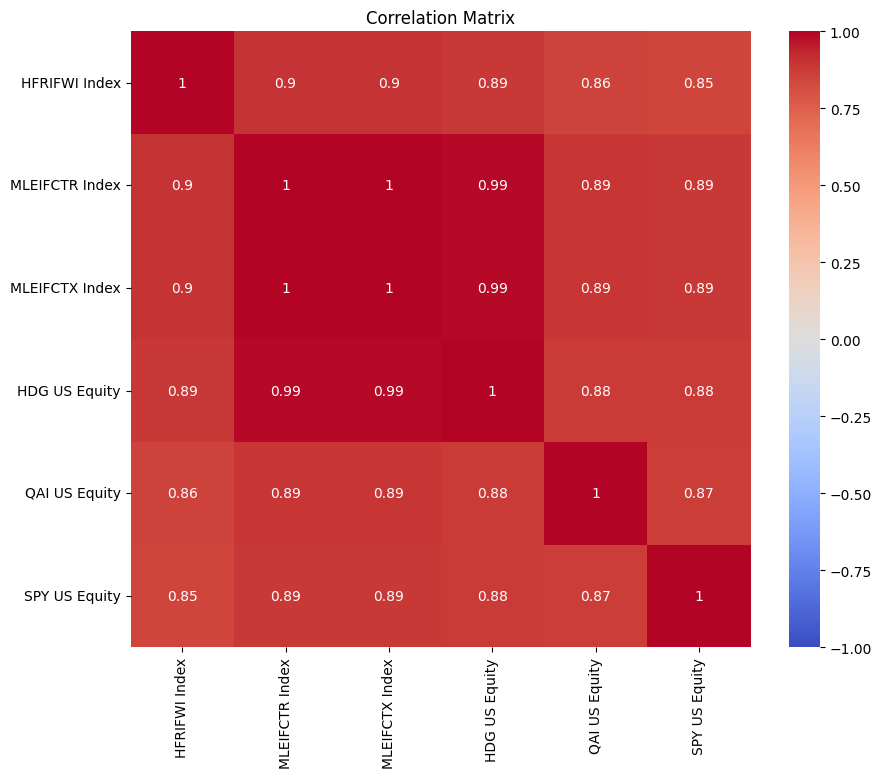

In [196]:
cols_w_spy = cols.join(spy, how = "inner")
corr = cols_w_spy.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

In [167]:
maxpair = corr.stack().idxmax()
maxvalue = corr.stack().max()
minpair = corr.stack().idxmin()
minvalue = corr.stack().min()

print(f'The maximum correlation is between {maxpair[0]} and {maxpair[1]}: {round(maxvalue,4)}.')
print(f'The minimum correlation is between {minpair[0]} and {minpair[1]}: {round(minvalue,4)}.')

The maximum correlation is between HFRIFWI Index and HFRIFWI Index: 1.0.
The minimum correlation is between HFRIFWI Index and QAI US Equity: 0.8578.


## 6.

Replicate HFRI with the six factors listed on the "merrill factors" tab. Include a constant, and run the unrestricted regression,

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{\merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\hat{r}^{\hfri}_{t} &= \hat{\alpha}^{\merr} + x_{t}^{\merr}\hat{\beta}^{\merr}
\end{align}$$

Note that the second equation is just our notation for the fitted replication.

a. Report the intercept and betas.

b. Are the betas realistic position sizes, or do they require huge long-short positions?

c. Report the R-squared.

d. Report the volatility of $\epsilon^{\merr}$, the tracking error.

In [ ]:
merrill_factors.columns = merrill_factors.columns.str.strip()
cols.columns = cols.columns.str.strip()

y_col = "HFRIFWI Index"                  
X_cols = list(merrill_factors.columns)  


df = cols[[y_col]].join(merrill_factors[X_cols], how="inner")

df = df.apply(pd.to_numeric, errors="coerce").dropna(how="any")

y = df[y_col]
X = sm.add_constant(df[X_cols])

ols = sm.OLS(y, X).fit()

y_hat = ols.fittedvalues
eps = ols.resid

alpha_hat = ols.params['const']
betas_hat = ols.params.drop('const')
coef_table = pd.DataFrame({"Estimate": [alpha_hat] + betas_hat.tolist()},
                          index=["alpha"] + betas_hat.index.tolist())
print("Coefficients (unrestricted OLS):")
display(coef_table)

# b) Position-size realism
gross = betas_hat.abs().sum()
net = betas_hat.sum()
print(f"Gross Exposure: {gross}, net exposure: {net}")

# c) R-squared
print(f"R-squared: {ols.rsquared:.4f}")

# d) Tracking error volatility
te = eps.std(ddof=1)
print(f"Tracking error: {te:.4%} per month")

Coefficients (unrestricted OLS):


,Estimate
alpha,0.001149
SPY US Equity,0.043503
USGG3M Index,0.324931
EEM US Equity,0.085564
EFA US Equity,0.073994
EUO US Equity,0.029614
IWM US Equity,0.145824


Gross Exposure: 0.7034302843974121, net exposure: 0.7034302843974121
R-squared: 0.8427
Tracking error: 0.6732% per month


- b: The gross exposure is 0.70 and the net exposure is 0.70.
Because all coefficients are between –1 and +1 and the gross exposure is below 2, the replication does not require extreme leverage or offsetting long–short positions. The betas represent realistic portfolio weights.
- c: The six factors explain about 84 % of the variation in hedge-fund index returns, showing that the Merrill model captures most systematic hedge-fund risk exposures.
- d: A tracking error of 0.67% per month corresponds to roughly 2.3 % annualized tracking error, indicating a close replication of the HFRI index.

## 7.

Let's examine the replication out-of-sample (OOS).

Starting with $t = 61$ month of the sample, do the following:

* Use the previous 60 months of data to estimate the regression equation. 
This gives time-t estimates of the regression parameters, $\tilde{\alpha}^{\merr}_{t}$ and $\tilde{\beta}^{\merr}_{t}$.

* Use the estimated regression parameters, along with the time-t regressor values, $x^{\merr}_{t}$, calculate the time-t replication value that is, with respect to the regression estimate, built "out-of-sample" (OOS).

$$\hat{r}^{\hfri}_{t} \equiv \tilde{\alpha}^{\merr} + (x_{t}^{\merr})'\tilde{\beta}^{\merr}$$

* Step forward to $t = 62$, and now use $t = 2$ through $t = 61$ for the estimation. Re-run the steps above, and continue this process throughout the data series. Thus, we are running a rolling, 60-month regression for each point-in-time.

How well does the out-of-sample replication perform with respect to the target?

In [169]:
window = 60

df_clean = (
    df[[y_col] + X_cols]        
    .astype(float)
    .dropna(how="any")
    .sort_index()
    .reset_index(drop=True)      
)

y = df_clean[y_col]
Xmat = df_clean[X_cols]

r_hat_oos = pd.Series(index=df_clean.index, dtype=float)

for i in range(window, len(df_clean)):
    y_tr  = y.iloc[i-window:i]
    X_trp = sm.add_constant(Xmat.iloc[i-window:i], prepend=True)

    ols = sm.OLS(y_tr, X_trp).fit()

    # PREDICT row i
    x_t = sm.add_constant(Xmat.iloc[i:i+1], prepend=True)

    # Align columns EXACTLY to what the model expects
    x_t = x_t.reindex(columns=ols.model.exog_names, fill_value=0.0)

    r_hat_oos.iloc[i] = ols.predict(x_t).iloc[0]


# Evaluate OOS
oos = r_hat_oos.dropna()
actual = y.loc[oos.index]

oos_corr = actual.corr(oos)
den = ((actual - actual.mean())**2).sum()
oos_R2 = np.nan if den == 0 else 1 - ((actual - oos)**2).sum() / den
te = (actual - oos).std(ddof=1); te_ann = te*np.sqrt(12)
mae = (actual - oos).abs().mean()

print(f"""
Out-of-Sample ({window}-month rolling regression):
Number of OOS observations : {len(oos):>5d}
Correlation (actual, fitted): {oos_corr:>6.3f}
OOS R-squared               : {oos_R2:>6.3f}
Tracking error (monthly)    : {te:>6.4%}
Tracking error (annualized) : {te_ann:>6.4%}
Mean absolute error (MAE)   : {mae:>6.4%}
""")


Out-of-Sample (60-month rolling regression):
Number of OOS observations :   109
Correlation (actual, fitted):  0.894
OOS R-squared               :  0.756
Tracking error (monthly)    : 0.8264%
Tracking error (annualized) : 2.8627%
Mean absolute error (MAE)   : 0.6469%



We can see unsuprisngly with the OOS, the R-squared is lower, and the TE is higher.

***

# 3. EXTRA - Other Estimations

### 1.

In `Section 2`, we estimated the replications using an intercept. Try the full-sample estimation, but this time without an intercept.

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\check{r}^{\hfri}_{t} &= \check{\alpha}^{\merr} + x_{t}^{\merr}\check{\beta}^{\merr}
\end{align}$$

Report

* the regression beta. How does it compare to the estimated beta with an intercept, $\hat{\beta}^{\merr}$?

* the mean of the fitted value, $\check{r}^{\hfri}_{t}$. How does it compare to the mean of the HFRI?

* the correlations of the fitted values, $\check{r}^{\hfri}_{t}$ to the HFRI. How does the correlation compare to that of the fitted values with an intercept, $\hat{r}^{\hfri}_{t}$

Do you think Merrill and ProShares fit their replicators with an intercept or not?

In [190]:
factor_cols = list(merrill_factors.columns)

df_clean = (
    cols[[y_col]]
    .join(merrill_factors[factor_cols], how="inner")  
    .dropna()
)

y = df_clean[y_col]
X = df_clean[factor_cols] 

ols_no_const = sm.OLS(y, X).fit()

betas_hat_no_const = ols_no_const.params

print(ols_no_const.summary())

print(betas_hat.corr(betas_hat_no_const))

                                 OLS Regression Results                                
Dep. Variable:          HFRIFWI Index   R-squared (uncentered):                   0.850
Model:                            OLS   Adj. R-squared (uncentered):              0.844
Method:                 Least Squares   F-statistic:                              153.6
Date:                Sun, 12 Oct 2025   Prob (F-statistic):                    2.09e-64
Time:                        19:04:27   Log-Likelihood:                          604.48
No. Observations:                 169   AIC:                                     -1197.
Df Residuals:                     163   BIC:                                     -1178.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

- we can see that the $r^2$ is less , the betas are 0.98 correlated
- I think they use intercept 

### 2.

Merrill constrains the weights of each asset in its replication regression of HFRI. Try constraining your weights by re-doing 2.6.

* Use Non-Negative Least Squares (NNLS) instead of OLS.
* Go further by using a Generalized Linear Model to put separate interval constraints on each beta, rather than simply constraining them to be non-negative.

#### Hints
* Try using LinearRegression in scikit-learn with the parameter `positive=True`. 
* Try using GLM in statsmodels.

In [212]:
from sklearn.linear_model import LinearRegression


x = merrill_factors

df = cols[[y_col]].join(merrill_factors, how="inner")
df = df.apply(pd.to_numeric, errors="coerce").dropna(how="any")

y = df[y_col]
X = df[X_cols]

model_nnls = LinearRegression(fit_intercept=True, positive=True).fit(X, y)
df = df.apply(pd.to_numeric, errors="coerce").dropna(how="any")

nnls_stats = pd.DataFrame(data = model_nnls.intercept_,index = ['const'],columns=['HFRIFWI'])
nnls_stats = pd.concat([nnls_stats, pd.DataFrame(data=model_nnls.coef_,index=X.columns,columns=['HFRIFWI'])])
nnls_stats.round(4)

,HFRIFWI
const,0.0011
SPY US Equity,0.0435
USGG3M Index,0.3249
EEM US Equity,0.0856
EFA US Equity,0.0740
EUO US Equity,0.0296
IWM US Equity,0.1458


In [213]:
X = sm.add_constant(df[X_cols])
y = df[y_col]

model = sm.GLM(y, X, family=sm.families.Gaussian(sm.families.links.identity()))
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          HFRIFWI Index   No. Observations:                  169
Model:                            GLM   Df Residuals:                      162
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                      4.6996e-05
Method:                          IRLS   Log-Likelihood:                 605.85
Date:                Sun, 12 Oct 2025   Deviance:                    0.0076133
Time:                        19:19:03   Pearson chi2:                  0.00761
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9941
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.001      1.631

/opt/anaconda3/envs/finm/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(


# 4. EXTRA - Other Decompositions

### 1. 

Let's decompose a few other targets to see if they behave as their name suggests.

* Regress HEFA on the same style factors used to decompose HFRI. Does HEFA appear to be a currency-hedged version of EFA?

* Decompose TRVCI with the same style factors used to decompose HFRI. The TRVCI Index tracks venture capital funds--in terms of our styles, what best describes venture capital?

* TAIL is an ETF that tracks SPY, but that also buys put options to protect against market downturns. Calculate the statistics in questions 2.1-2.3 for TAIL. Does it seem to behave as indicated by this description? That is, does it have high correlation to SPY while delivering lower tail risk?

### 2. 

The ProShares case introduces Levered ETFs. ProShares made much of its name originally through levered, or "geared" ETFs.

Explain conceptually why Levered ETFs may track their index well for a given day but diverge over time. How is this exacerbated in volatile periods like 2008?

### 3.

Analyze SPXU and UPRO relative to SPY.
- SPXU is ProShares -3x SPX ETF.
- UPRO is ProShres +3x SPX ETF.

Questions:
* Analyze them with the statistics from 2.1-2.3. 

* Do these two ETFs seem to live up to their names?

* Plot the cumulative returns of both these ETFs along with SPY.

* What do you conclude about levered ETFs?

***